In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from tqdm import tqdm
mpl.rcParams['figure.dpi']= 200

In [59]:
X_train = pd.read_csv("X_train.csv", header=None).to_numpy()
X_test = pd.read_csv("X_test.csv", header=None).to_numpy()
y_train = pd.read_csv("y_train.csv", header=None).to_numpy()
y_test = pd.read_csv("y_test.csv", header=None).to_numpy()

In [69]:
np.unique(y_train, return_counts=True)[1]/y_train.shape[0]
np.unique(y_test, return_counts=True)[1]/y_test.shape[0]
#X_train.shape, X_test.shape

array([0.46575342, 0.53424658])

## Random Forest Classifier

In [85]:
# TRAIING
# on a bunch of models, first do 5-fold CV, then choose "best" one, finally test model on test data
depths = np.int64(np.linspace(1, 50, 25, endpoint=True))
rfc_cv_scores = []
rfc_models = []
for depth in depths:
    rfc = RandomForestClassifier(max_depth=depth, n_estimators=15, max_features=1, bootstrap=True, random_state=0) # check what random state's for
    score = np.mean(cross_val_score(rfc, X_train, y_train[:,0], cv=5))
    print("depth " + str(depth) + ": " + str(score))
    rfc_cv_scores = rfc_cv_scores + [score]
    rfc_models = rfc_models + [rfc]
    # if depth == depths[-1]:
    #     pickle.dump(rfc, open("rf_model", "wb"))
rfc_optim_model = rfc_models[np.argmax(rfc_cv_scores)]
pickle.dump(rfc_optim_model, open("rf_model", "wb"))

depth 1: 0.7638477801268498
depth 3: 0.7873150105708245
depth 5: 0.7917547568710359
depth 7: 0.759090909090909
depth 9: 0.8145877378435518
depth 11: 0.8426004228329809
depth 13: 0.8193446088794927
depth 15: 0.8239957716701903
depth 17: 0.828646934460888
depth 19: 0.828646934460888
depth 21: 0.828646934460888
depth 23: 0.828646934460888
depth 25: 0.828646934460888
depth 27: 0.828646934460888
depth 29: 0.828646934460888
depth 31: 0.828646934460888
depth 33: 0.828646934460888
depth 35: 0.828646934460888
depth 37: 0.828646934460888
depth 39: 0.828646934460888
depth 41: 0.828646934460888
depth 43: 0.828646934460888
depth 45: 0.828646934460888
depth 47: 0.828646934460888
depth 50: 0.828646934460888


In [86]:
# PREDICT
#  now we try on test data, note that you can just run this cell instead of training models above ^, rf_model stores the tuned RF. 
#rfc_optim_model = pickle.load(open("rf_model", "rb"))
rfc_optim_model.fit(X_train, y_train)
rfc_optim_model.score(X_test, y_test)

/var/folders/q9/_w8r3x510lqdsg7hgplq2m7w0000gn/T/ipykernel_82897/2994967499.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_optim_model.fit(X_train, y_train)


0.8493150684931506

## AdaBoost

In [88]:
# TRAINING
# on a bunch of models, first do 5-fold CV, then choose "best" one, finally test model on test data
estimators = [1, 5, 15, 25, 50, 75]
ada_cv_scores = []
ada_models = []
for estimator in estimators:
    abc = AdaBoostClassifier(n_estimators=estimator)    
    score = np.mean(cross_val_score(abc, X_train, y_train[:,0], cv=5))
    print("estimator " + str(estimator) + ": " + str(score))
    ada_cv_scores = ada_cv_scores + [score]
    ada_models = ada_models + [abc]
ada_optim_model = ada_models[np.argmax(ada_cv_scores)]
pickle.dump(ada_optim_model, open("ada_model", "wb"))

estimator 1: 0.8566596194503171
estimator 5: 0.824630021141649
estimator 15: 0.8378435517970401
estimator 25: 0.8933403805496829
estimator 50: 0.8886892177589851
estimator 75: 0.8979915433403806


In [90]:
# PREDICT
# now we try on test data, same as before - no need to run cell above again, just run the model
ada_optim_model = pickle.load(open("ada_model", "rb"))
ada_optim_model.fit(X_train, y_train[:,0])
ada_optim_model.score(X_test, y_test[:,0])

0.9041095890410958

## XGBoost

In [91]:
# TRAINING
# We have many hyper-parameters to tune, so RandomizedSearchCV might be better to use here
# Note that before we tuned for n_estimators and max_depth, so we can just use those in XGBoost
params = {'learning_rate': [0.1, 0.01, 0.001],
            'max_depth': [5, 10, 15, 20, 25, 30],
            'n_estimators': [100, 200, 300, 400, 500],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [0, 0.1, 0.5, 1]}
xgb_model = xgb.XGBClassifier()
rs_classifier = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, cv=5, n_jobs=-1)
rs_classifier.fit(X_train, y_train[:,0])
xgb_optim_model = xgb.XGBClassifier(**rs_classifier.best_params_)
pickle.dump(xgb_optim_model, open("xgb_model", "wb"))

In [94]:
# PREDICT
xgb_optim_model = pickle.load(open("xgb_model", "rb"))
xgb_optim_model.fit(X_train, y_train[:,0])
xgb_optim_model.score(X_test, y_test[:,0])

0.9041095890410958

## Confusion Matrices for Models
(just use the variable where you store your model in predict in first line)

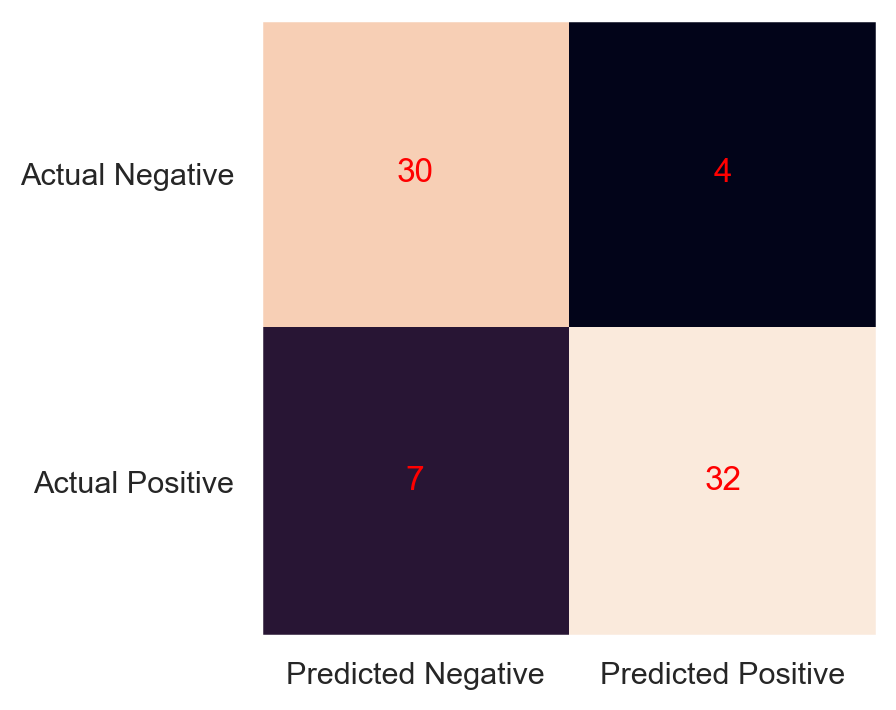

In [98]:
cm = metrics.confusion_matrix(y_test, rfc_optim_model.predict(X_test))
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative', 'Predicted Positive'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negative', 'Actual Positive'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## ROC/AUC (also LogReg so that they're all together)

Text(0.5, 1.0, 'ROC for Models')

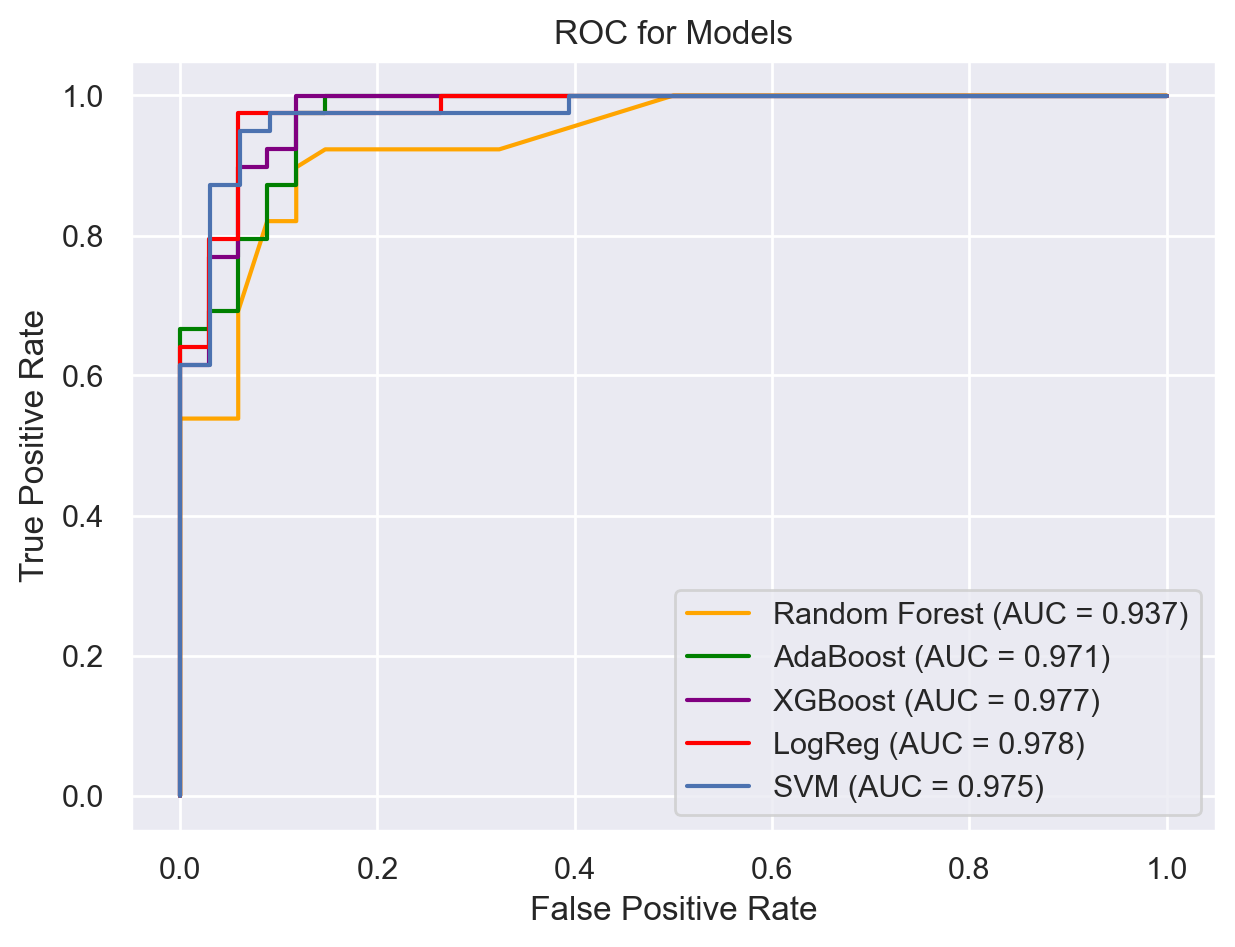

In [102]:
log_reg_fpr = pd.read_csv("log_reg_roc_fpr.csv", header=None).to_numpy()
log_reg_tpr = pd.read_csv("log_reg_roc_tpr.csv", header=None).to_numpy()
svm_fpr = [0, 0, 0, 0.03030303, 0.03030303, 0.06060606, 0.06060606, 0.09090909, 0.09090909, 0.39393939, 0.39393939, 1]
svm_tpr =  [0, 0.02564103, 0.61538462, 0.61538462, 0.87179487, 0.87179487, 0.94871795, 0.94871795, 0.97435897, 0.97435897, 1, 1]

sns.set(rc={"figure.figsize":(7,5)})
rf_auc = round(roc_auc_score(y_test, rfc_optim_model.predict_proba(X_test)[:,1]), 3)
ada_auc = round(roc_auc_score(y_test, ada_optim_model.predict_proba(X_test)[:,1]), 3)
xgb_auc = round(roc_auc_score(y_test, xgb_optim_model.predict_proba(X_test)[:,1]), 3)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, rfc_optim_model.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, _ = metrics.roc_curve(y_test, ada_optim_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_test, xgb_optim_model.predict_proba(X_test)[:,1])
plt.plot(rf_fpr, rf_tpr, label="Random Forest (AUC = " + str(rf_auc) + ")", color="orange")
plt.plot(ada_fpr, ada_tpr, label="AdaBoost (AUC = " + str(ada_auc) + ")", color="green")
plt.plot(xgb_fpr, xgb_tpr, label="XGBoost (AUC = " + str(xgb_auc) + ")", color="purple")
plt.plot(log_reg_fpr, log_reg_tpr, label="LogReg (AUC = 0.978)", color="red")
plt.plot(svm_fpr, svm_tpr, label="SVM (AUC = 0.975)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC for Models")

In [ ]:
# sns.set(rc={"figure.figsize":(12,5)})
# sns.lineplot(x=depths,y=rfc_cv_scores, marker="o")
# plt.xlabel("Forest depth")
# plt.ylabel("Average 5-fold CV score")
# plt.title("Determining RF depth via CV")
# #plt.savefig("rfs_cv.png")

# sns.set(rc={"figure.figsize":(12,5)})
# sns.lineplot(x=estimators,y=ada_cv_scores, marker="o")
# plt.xlabel("# of estimators (weak learners)")
# plt.ylabel("Average 5-fold CV score")
# plt.title("Determining AdaBoost Estimators via CV")
# #plt.savefig("adaboost_cv.png")

In [39]:
X_train.shape

(215, 35981)